# 이미지 생성 모델
- Latent Space에서 샘플링하여 완전히 새로운 이미지나 기존 이미지를 변형시키는 방식의 주요 기법
    - 변이형 오토인코더 (Variational AutoEncoders, VAE)
    - 적대정 생성 네트워크 (Generative Adversarial Networks, GAN)
- Latent Space의 한 포인트를 입력으로 받아 이미지(픽셀의 그리드)를 출력하는 모듈을 VAE에서는 디코더 라고 함
- Latent Space는 뭔가 정보가 많이 집약되어 있는 공간?

## VAE의 훈련
    - 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss)
    - 잠재 공간을 잘 형성하고 training set의 overfitting 을 줄이는 regularization loss

## VAE 구현 pseudocode

    z_mean, z_log_var = encoder(input_img)
    z = z_mean + exp(0.5 * z_log_var) * epsilon
    reconstructed_img = decoder(z)
    model = Model(input_img, reconstructed_img)

# Convolutional VAE
- MNIST Dataset
- 코드 참조: https://www.tensorflow.org/tutorials/generative/cvae?hl=ko

## 모듈 설치

In [ ]:
!pip install tensorflow-probability
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import numpy as np
import PIL
import time

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.data import Dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

## 데이터 로드

In [ ]:
(train_images, _), (test_images, _) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


## 데이터 전처리

In [ ]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images >.5, 1.0, 0.0).astype('float32')

In [ ]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

## tf.data를 사용하여 데이터 일괄 처리 및 섞기


In [ ]:
train_dataset = (Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

## 인코더, 디코더 모델 구성
- VAE 예제에서는 인코더 및 디코더 2개로 이루어진 작은 ConvNet을 사용
- 자세한 네트워크 구성 설명은 링크 참조
    - https://www.tensorflow.org/tutorials/generative/cvae?hl=ko

In [ ]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([InputLayer(input_shape=(28, 28, 1)),
                                   Conv2D(filters=32, kernel_size=3,
                                          strides=(2, 2), activation='relu'),
                                   Conv2D(filters=64, kernel_size=3, 
                                          strides=(2, 2), activation='relu'),
                                   Flatten(),
                                   Dense(latent_dim + latent_dim)])
        self.decoder = Sequential([InputLayer(input_shape=(latent_dim, )),
                                   Dense(units=7*7*32, activation='relu'),
                                   Reshape(target_shape=(7, 7, 32)),
                                   Conv2DTranspose(filters=64, kernel_size=3,
                                                   strides=2, padding='same',
                                                   activation='relu'),
                                   Conv2DTranspose(filters=32, kernel_size=3,
                                                   strides=2, padding='same',
                                                   activation='relu'),
                                   Conv2DTranspose(filters=1, kernel_size=3,
                                                   strides=1, padding='same'),])
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)    # latent variable 의 값

        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits


## 손실 함수 및 최적화 프로그램 정의
- VAE는 한계 로그 우도에서 증거하한(ELBO)을 최대화 하여 학습
$$logp(x) \geq ELBO = \mathbb{E}_{q(z|x)} \left[log\frac{p(x,z)}{q(z|x)}\right]$$
- 실제로 우리는 이 기대치의 단일 샘플 Monte Carlo 추정치를 최적화
$$logp(x|z) + logp(z) - logq(z|x)$$

In [ ]:
optimizer = Adam(1e-4)

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample-mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimzer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 모델 학습 및 이미지 생성

In [ ]:
epochs = 10

latent_dim = 2  # 2x2
num_examples_to_generate = 16

In [ ]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epochs, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epochs))
    plt.show()

In [ ]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

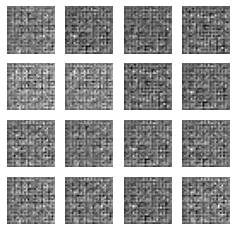

In [ ]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -153.62237548828125, Time: 6.67939567565918


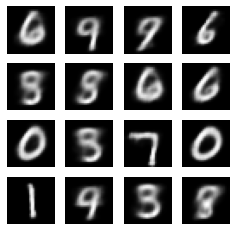

In [ ]:
for epoch in range(1, epochs+1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, Time: {}'.format(epoch, elbo, (end_time-start_time)))
    generate_and_save_images(model, epoch, test_sample)

## 학습 시각화
- 마지막 훈련 스텝에서 생성된 이미지표 

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

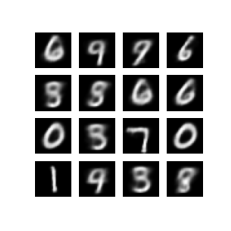

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')

- 저장된 모든 이미지의 애니메이션 GIF 표시

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

- 잠재 공간에서 2D 다양한 숫자 표시

In [ ]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i , yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i+1) * digit_size, 
                  j * digit_size: (j+1) * digit_size] = digit.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.show()

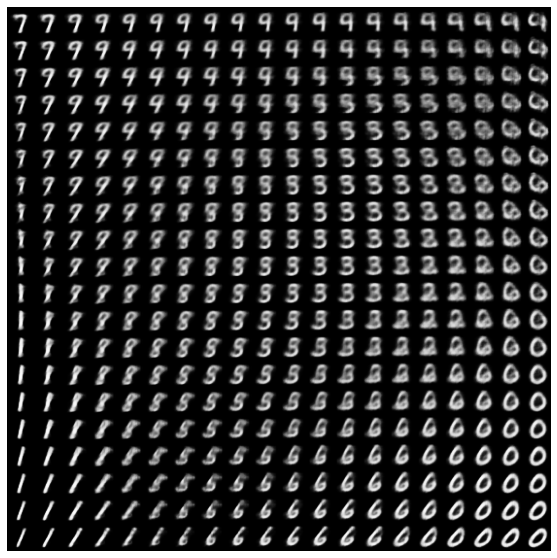

In [ ]:
plot_latent_images(model, 20)